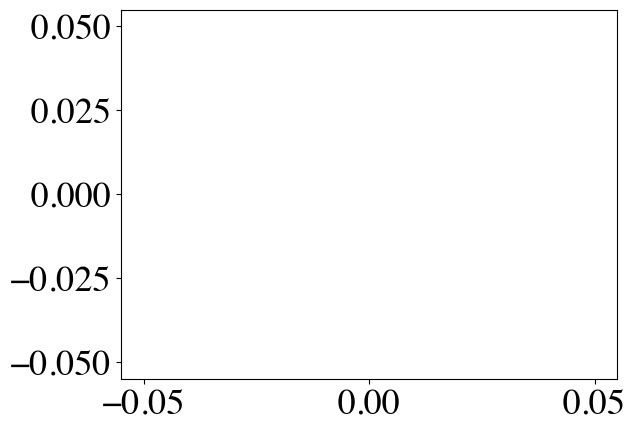

In [1]:
####### Imports and plotting utils definitions
## Modified from https://github.com/Chuneeta/beam_solver/blob/master/beam_solver/fits_utils.py

import numpy as np
from astropy.io import fits
from astropy import wcs
from astropy.cosmology import LambdaCDM
import aplpy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import ticker,cm
from matplotlib import colors
from colormaps import spectral
from matplotlib.colors import ColorConverter
from matplotlib.colors import LogNorm
from numpy.ma import masked_array
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
from astropy.coordinates import AltAz, EarthLocation, SkyCoord
from astropy.time import Time
from astropy import units as u
from reproject import reproject_from_healpix
import glob
import healpy as hp
import os
import scipy
import pylab as pl
from astropy.wcs import WCS
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from scipy import optimize
from matplotlib.backends.backend_pdf import PdfPages

# Font properties
# Note: TNR required for bolding due to font manager bug
# Math font for compact, times-like scientific notation
# Exit out of notebook before changing
times_font=True
if times_font:
    font_bold = fm.FontProperties(family='Times New Roman', style='normal', size=32, weight='bold', stretch='normal')
    font      = fm.FontProperties(family='Times', style='normal', size=14, weight='normal', stretch='normal')
    font_name ='Times'
    plt.rcParams["mathtext.fontset"] = "stixsans"
    plt.rcParams['font.family'] = 'Times'
else:
    font_name ='Dejavu Sans'
    font_bold = fm.FontProperties(family='Dejavu Sans', style='normal', size=14, weight='bold', stretch='normal')
    font      = fm.FontProperties(family='Dejavu Sans', style='normal', size=14, weight='normal', stretch='normal')  

# Set defaults for plot font and size
matplotlib.rc('font', size=26)
matplotlib.rc('axes', labelsize=26)    
    
# Color map
cb_spec, cb_spec_r = spectral()
cb_spec.set_bad('white')

# Colorbar
colorbar_scale_catalog = plt.pcolor([0,0], [0,0], [[0,0],[0,0]] ,norm=colors.Normalize(vmin=0, vmax=6000),
            cmap=cb_spec)#'Spectral_r')
colorbar_scale_nobeam = plt.pcolor([0,0], [0,0], [[0,0],[0,0]] ,norm=colors.Normalize(vmin=-6000, vmax=6000),
            cmap=cb_spec)#'Spectral_r')
colorbar_scale_inst = plt.pcolor([0,0], [0,0], [[0,0],[0,0]] ,norm=colors.Normalize(vmin=-50, vmax=50),
            cmap=cb_spec)#'Spectral_r')
colorbar_scale_data = plt.pcolor([0,0], [0,0], [[0,0],[0,0]] ,norm=colors.Normalize(vmin=-100, vmax=100),
            cmap=cb_spec)#'Spectral_r')

## Plotting parameters for colors and plot locations
# Spectral custom colors
ColorConverter.colors['e']=(94/256, 79/256, 162/256)
ColorConverter.colors['g']=(50/256, 136/256, 189/256)
ColorConverter.colors['h']=(102/256, 194/256, 165/256)
ColorConverter.colors['i']=(253/256, 174/256, 97/256)
ColorConverter.colors['j']=(219/256, 55/256, 82/256)
    
#utilities
def get_fitsinfo(fitsfile):
    """
    Extracts data and header information (metadata) from fits file
    fitsfile: Input fitsfile
    """
    data, hdr = fits.getdata(fitsfile, header=True)
    data = data.squeeze()
    freq = 182. #hdr ['CRVAL3']
    #nxaxis = hdr['NAXIS1']
    #nyaxis = hdr['NAXIS2']
    return {'data':data, 'hdr':hdr, 'freq':freq} #, 'nxaxis':nxaxis, 'nyaxis':nyaxis}

In [92]:
def read_obs_ids(days, dir_obsids):
    #
    # Read observations from day/pointing observation files, return list of obs
    # Return array is in
    
    pointingnames=['_minustwo_ssins','_minusone_ssins','_zenith_ssins','_plusone_ssins','_plustwo_ssins']
    
    obs_list = []
    n_obs = 0
     
    obs_list = np.zeros((15,len(pointingnames),len(days)))
    
    for day_i,day in enumerate(days):
        pointing_list = []
        
        for poi_i,pointingname in enumerate(pointingnames):
            with open(dir_obsids + day + pointingname + '.txt') as f:
                lines = [line.rstrip() for line in f]
                n_obs += len(lines)
                
            if len(lines) > 0:
                if lines[0] != '':
                    obs_list[0:len(lines),poi_i,day_i] = lines


    return obs_list, n_obs

##############
def read_flag_stats(obs_ids, dir_plt):
    #
    # Read the flagging stats of the observation overall from aoflagger
    
    all_flag_stats = np.load(f'{dir_plt}/flag_stats.npy')
    
    flag_stats = np.empty(len(obs_ids.flatten()))
    flag_stats[:] = np.nan
    temp, flag_stats_indx, obs_ids_indx  = np.intersect1d(all_flag_stats[:,0], obs_ids.flatten(), 
                                                          return_indices=True)
    
    flag_stats[obs_ids_indx] = all_flag_stats[flag_stats_indx,1]                      
    flag_stats = np.array(flag_stats.reshape(obs_ids.shape))                      
    
    return flag_stats

##############
def write_obs_ids(unflagged_obs_list, txt_name, days, dir_obsids):
    #
    # Write the observations in the day/pointing format
    
    pointingnames=['_minustwo_ssins','_minusone_ssins','_zenith_ssins','_plusone_ssins','_plustwo_ssins']
    
    if not os.path.exists(dir_obsids + txt_name): 
        os.makedirs(dir_obsids + txt_name) 
    
    with open(dir_obsids + txt_name + '/' + txt_name + '.txt','w') as f:
        for day_i,day in enumerate(days):
                for poi_i,pointingname in enumerate(pointingnames):
                    for obs_i,obs_id in enumerate(unflagged_obs_list[:,poi_i,day_i]):
                            if obs_id != 0:
                                f.write(str(int(unflagged_obs_list[obs_i,poi_i,day_i]))+'\n')
                                
    for day_i,day in enumerate(days):
        for poi_i,pointingname in enumerate(pointingnames):
            with open(f"{dir_obsids}{txt_name}/{day}_{pointingname}_{txt_name}.txt",'w') as f:
                for obs_i,obs_id in enumerate(unflagged_obs_list[:,poi_i,day_i]):
                    if obs_id != 0:
                        f.write(str(int(unflagged_obs_list[obs_i,poi_i,day_i]))+'\n')                            
    
    return

##############
def read_fits_files(days, dir_plt):
    #
    # Read the calculated delay arrays per day in fits file format
    
    with fits.open(dir_plt + 'kperp_edges.fits') as hdu:
        kperp_edges = hdu[0].data
    with fits.open(dir_plt + 'kpar_edges.fits') as hdu:
        kpar_edges = hdu[0].data
    
    data = np.zeros((15,5,len(days),2,kpar_edges.size-1,kperp_edges.size-1))
    data[:,:,:,:,:,:] = np.nan
    
    for day_i,day in enumerate(days):
        with fits.open(dir_plt + 'full_delay_arr_' + day + '.fits') as hdu:
            day_data = hdu[0].data
            data[0:day_data.shape[0],:,day_i,:,:,:] = np.flip(day_data[:,:,0,:,:,:], axis=3)
    
    return data, kperp_edges, kpar_edges

def read_txt_files(days, dir_plt, obs_list):
    #
    # Read the tv ratio text files, put them in observation, pointing, day, pol array
    pointingnames=['_minustwo_ssins','_minusone_ssins','_zenith_ssins','_plusone_ssins','_plustwo_ssins']
    
    tv_ratio_array = np.zeros((obs_list.shape[0], obs_list.shape[1], obs_list.shape[2], 2))
    tv_ratio_array[:] = np.nan
    
    for day_i,day in enumerate(days):
        # Open the text file in read mode
        with open(dir_plt + 'tv_ratio_day_' + days[day_i] + '.txt', 'r') as file:
            lines = file.readlines()

        # Remove duplicate entries using a set
        unique_lines = list(set(lines))
            
        # Split columns into separate lists
        columns = [line.split() for line in unique_lines]

        # Convert the list of columns to a NumPy array
        columns_array = np.array(columns, dtype=float).reshape(-1, 3)
        
        for poi_i,pointingname in enumerate(pointingnames):
            for obs_i,obs_id in enumerate(obs_list[:,poi_i,day_i]):
                
                matching_indices = np.argwhere(obs_id == columns_array[:,0])
                
                if matching_indices.size > 0:  
                    tv_ratio_array[obs_i,poi_i,day_i,0] = columns_array[matching_indices,1]
                    tv_ratio_array[obs_i,poi_i,day_i,1] = columns_array[matching_indices,2]
            
    
    return tv_ratio_array

##############
def plot_delay(data, kperp_edges, kpar_edges, savefig):
    
    fig, ax = plt.subplots(1,1,figsize=(6,7))
    
    hubble=.7
    data = data * hubble**3
    kperp_edges = kperp_edges / hubble
    kpar_edges = kpar_edges / hubble
    
    # configure color map
    cmap = cm.get_cmap("Spectral_r")
    upper = (np.log10(3e13)) #[6e12,3e13]
    lower = (np.log10(6e12))
    cmap.set_bad(cmap(0))
    ticks = [tick for tick in np.arange(np.ceil(lower), np.ceil(upper) + 1, 1)]
    ticklabels = ["1e+{:d}".format(int(tick)) for tick in ticks]
    bounds = []
    for bound in np.linspace(lower, upper, cmap.N):
        bounds.append(bound)
        
    norm = colors.BoundaryNorm(bounds, cmap.N)
         
    data = masked_array(data, data <= 0)
    data = np.flip(data, axis=0)
    
    ##make an 'extent' list for imshow, that details x,y coords for a 2D plot
    ##goes as [low x coord, high x coord, low y coord, high y coord]
    kperp_center = (kperp_edges[1:-1]+kperp_edges[0:-2])/2.
    inds = np.where(kperp_center < .3)[0]
    data = data[:,inds]
    kperp_center = kperp_center[inds]
    kperp_edges = kperp_edges[inds]
    inds = np.where(kperp_center > .01)[0]
    data = data[:,inds]
    kperp_center = kperp_center[inds]
    kperp_edges = kperp_edges[inds]
    kpar_center = (kpar_edges[1:-1]+kpar_edges[0:-2])/2.
    inds = np.where(kpar_center < 4)[0]
    data = data[inds,:]
    kpar_center = kpar_center[inds]
    kpar_edges = kpar_edges[inds]
    inds = np.where(kpar_center > .003)[0]
    data = data[inds,:]
    kpar_center = kpar_center[inds]
    kpar_edges = kpar_edges[inds]
    

    
    extent = [kperp_edges[0], kperp_edges[-1], kpar_edges[0], kpar_edges[-1]]
    
    im = ax.imshow(np.log10(data), cmap=cmap, origin='lower',
                norm=norm, aspect='auto', extent=extent,
                interpolation='none')
    
    ##Append a smaller axis to plot the colourbar on
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.15)

    cb = fig.colorbar(im, cax=cax, format='%.0e',extend='both',
                      ticks=ticks)
    cb.ax.set_yticklabels(ticklabels)
    cb.ax.tick_params(labelsize=12)
    cax.set_ylabel(r'P(k) mK$^2$ $h^{-3}$ Mpc$^3$',fontsize=14)


    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.set_xlabel(r'k$_\bot$ ($h$Mpc$^{-1}$)',fontsize=18)
    ax.set_ylabel(r'k$_\parallel$ ($h$Mpc$^{-1}$)',fontsize=18)
    ax.set_xscale("log")
    ax.set_yscale("log")

    plt.savefig(savefig + 'delay_plot_diagnostic.png', bbox_inches='tight', dpi=300)
    plt.close()



##############
def horizon_mask(kperp_edges, kpar_edges, wedge_factor, data_shape):  

    #Calculate k centers from input k edges
    n_k = kpar_edges.size
    kpar_center = (kpar_edges[1:(n_k)]+kpar_edges[0:(n_k-1)])/2.
    n_k=kperp_edges.size
    kperp_center = (kperp_edges[1:(n_k)]+kperp_edges[0:(n_k-1)])/2.

    #Create 2D tile arrays for kperp, kpar, and calculate their cylindrical k
    kperp_2d = np.tile(kperp_center, (kpar_center.size,1))
    kpar_2d = np.tile(np.flip(kpar_center)[:, np.newaxis], (1,kperp_center.size))
    cylindrical_k = kperp_2d**2. + kpar_2d**2

    #Calculate min,max 2D arrays of the wedge factors for masking
    wedge_amp_norm = wedge_factor * np.pi / 180 * np.array([120,100]) 
    wedge_amp = wedge_factor * np.pi / 180 * np.array([70,45]) 
    #wedge_amp = wedge_factor * np.pi / 180 * np.array([70,70]) 
    wedge_line_norm_high = (kperp_2d*wedge_amp_norm[0])**2. + kperp_2d**2.
    wedge_line_norm_low = (kperp_2d*wedge_amp_norm[1])**2. + kperp_2d**2.
    wedge_line_high = (kperp_2d*wedge_amp[0])**2. + kperp_2d**2.
    wedge_line_low = (kperp_2d*wedge_amp[1])**2. + kperp_2d**2.
    
    #Calculate which indices fall outside the suggested slices of k
    inds_near_horizon = np.argwhere( ((cylindrical_k - wedge_line_low) < 0) | 
                                    ((cylindrical_k - wedge_line_high) > 0) ) 
    inds_norm_horizon = np.argwhere( ((cylindrical_k - wedge_line_norm_low) < 0) | 
                                    ((cylindrical_k - wedge_line_norm_high) > 0) ) 
    inds_mask_horizon = np.argwhere( ((cylindrical_k - wedge_line_high) < 0) )
    
    #Create a mask that leaves a window on the horizon--first sidelobe, but without missubtracted foregrounds
    #Create a mask of leaves a known region unaffected pixels to calculate base levels for normalization 
    mask_near_horizon = np.ones((kpar_center.size, kperp_center.size))    
    mask_norm_horizon = np.copy(mask_near_horizon) 
    mask_horizon = np.copy(mask_near_horizon)  
    mask_near_horizon[inds_near_horizon[:,0],inds_near_horizon[:,1]] = 0
    mask_norm_horizon[inds_norm_horizon[:,0],inds_norm_horizon[:,1]] = 0
    mask_horizon[inds_mask_horizon[:,0],inds_mask_horizon[:,1]] = 0

    return mask_near_horizon, mask_norm_horizon, mask_horizon

def mask_data(mask, data, data_shape, extra_masking=False, masking_kperpkpar = False, extra_averaging=False):

    full_mask = np.copy(mask)
    
    if extra_masking:
        for extra_i, extra_inds in enumerate(np.array(extra_masking).reshape([-1,2])):
            if masking_kperpkpar[extra_i] == 0:
                full_mask[extra_inds[0]:extra_inds[1],:] = 0
            if masking_kperpkpar[extra_i] == 1:
                full_mask[:,extra_inds[0]:extra_inds[1]] = 0

    n_pix = np.sum(full_mask)
    
    full_mask = np.tile(full_mask[None,None,None,None,:,:], (data_shape[0], data_shape[1], data_shape[2], data_shape[3], 1, 1))
        
    data = data * full_mask
    
    if extra_averaging:        
        average_data = np.nansum(data, extra_averaging) / n_pix
        average_data[average_data == 0] = np.nan 
        
        return average_data, n_pix
    else:
        return data, n_pix
    
def apply_flags(data, flag_array):
    
    data = data * flag_array
    data[data == 0] = np.nan
    
    return data

##############
def metric_1(average_near_horizon, average_norm_horizon, flag_array, data_shape, n_obs, obs_list, standard_dev=3, 
             binsize=.01, min_bin=1.5, max_bin=3.5, savefig = False):
    #Initial check to grab extreme outiers of horizon emission to prevent skewing the mean

    n_xx = 0
    n_yy = 0
    
    hist_color=['j','e']
    
    if savefig:
        fig = plt.figure(figsize=(21,21))
        xmin = .1
        ymax = .9
        xspace = .2
        subplot_loc = np.zeros((4,5))
        subplot_loc[:,0] = [xmin,ymax,xspace,xspace]
        subplot_loc[:,1] = [xmin+xspace+.01,ymax,xspace,xspace]
        subplot_loc[:,2] = [xmin,ymax-xspace-.01,xspace,xspace]
        subplot_loc[:,3] = [xmin,ymax-2*(xspace+.01),xspace,xspace]
        subplot_loc[:,4] = [xmin+xspace+.01,ymax-2*(xspace+.01),xspace,xspace]
        plt.rcParams.update({'axes.facecolor':'aliceblue'})
        plt.rcParams.update({'font.size': 25})
        poi_name = ['Two pointings\nbefore zenith','One pointing\nbefore zenith', 'Zenith', 'One pointing\nafter zenith',
                   'Two pointings\nafter zenith']
        
    near_horizon_median = np.zeros((average_near_horizon.shape[1],average_near_horizon.shape[3]))
    near_horizon_stddev = np.zeros((average_near_horizon.shape[1],average_near_horizon.shape[3]))
    bins = np.arange(min_bin, max_bin + binsize, binsize)
    hist_arr = np.zeros((average_near_horizon.shape[1],average_near_horizon.shape[3],bins.size-1))
    
    for poi_i in range(data_shape[1]):
        for pol_i in range(data_shape[3]):

            while_flag = 1
            while while_flag > 0:

                near_horizon_median[poi_i,pol_i] = np.nanmedian(average_near_horizon[:,poi_i,:,pol_i]/1e13)
                near_horizon_stddev[poi_i,pol_i] = np.nanstd(average_near_horizon[:,poi_i,:,pol_i]/1e13)
                outlier_inds = np.argwhere((average_near_horizon[:,poi_i,:,pol_i]/1e13) > (near_horizon_median[poi_i,pol_i] + standard_dev*near_horizon_stddev[poi_i,pol_i])) 

                #flag to keep the while loop going -- if there are really extreme outliers, redo the calculation until there are none left.
                temp = np.argwhere((average_near_horizon[:,poi_i,:,pol_i]/1e13) > (2*near_horizon_median[poi_i,pol_i]))
                while_flag = temp.size

                if savefig:
                    #histogram is within the while loop in case in-situ graphs want to be made with each cut
                    hist, bin_edges = np.histogram(average_near_horizon[:,poi_i,:,pol_i]/1e13, bins=bins)
                    hist_arr[poi_i,pol_i,:] = hist[:]

                if outlier_inds.size > 0:
                    for outlier in np.array(outlier_inds).reshape([-1,2]):
                        flag_array[outlier[0],poi_i,outlier[1],pol_i] = 0
                        average_near_horizon[outlier[0],poi_i,outlier[1],pol_i] = np.nan
                        average_norm_horizon[outlier[0],poi_i,outlier[1],pol_i] = np.nan
                        if pol_i == 0:
                            n_xx += 1
                        else:
                            n_yy += 1

        if savefig:
            
            width = (bin_edges[1]- bin_edges[0])
            plt.axes(subplot_loc[:,poi_i])

            plt.bar(bin_edges[1:], hist_arr[poi_i,0,:]/max(hist_arr[poi_i,0,:]), width=width, color=hist_color[0], alpha = 0.75, 
                    edgecolor=hist_color[0])
            plt.bar(bin_edges[1:], hist_arr[poi_i,1,:]/max(hist_arr[poi_i,1,:]), width=width, color=hist_color[1], alpha = 0.75, 
                    edgecolor=hist_color[1])
    
            plt.plot([near_horizon_median[poi_i,0] + standard_dev*near_horizon_stddev[poi_i,0],
                      near_horizon_median[poi_i,0] + standard_dev*near_horizon_stddev[poi_i,0]], 
                     [0,max(hist_arr[poi_i,0]*2)],linestyle='dotted', color=hist_color[0],linewidth=4)
            plt.plot([near_horizon_median[poi_i,1] + standard_dev*near_horizon_stddev[poi_i,1],
                      near_horizon_median[poi_i,1] + standard_dev*near_horizon_stddev[poi_i,1]], 
                     [0,max(hist_arr[poi_i,1]*2)],linestyle='dotted', color=hist_color[1],linewidth=4)
            fig.text((subplot_loc[:,poi_i])[0]+.1, (subplot_loc[:,poi_i])[1]+.16, poi_name[poi_i],rotation='horizontal',
                multialignment='center',fontsize=25,fontproperties=font)
            
            plt.ylim([0,1.1])
            if (poi_i == 0) | (poi_i == 1) | (poi_i == 2): 
                plt.xticks([])   
            if (poi_i == 1) | (poi_i == 4):
                plt.yticks([])
            if (poi_i == 0) | (poi_i == 2) | (poi_i == 3):
                plt.yticks([0.0,0.5,1.0]) 
            if poi_i == 2:
                plt.ylabel('Normalised observation count',fontsize=35)
                
    concate_inds = np.argwhere((flag_array[:,:,:,0] + flag_array[:,:,:,1]) < 2)
    n_flags = concate_inds.shape[0]             

    if savefig:
        fig.text(xmin+xspace/2-.07, ymax-2*(xspace+.01)-.04, 'Power near horizon (1e13 mK$^2$ h$^{-3}$ Mpc$^3$)',rotation='horizontal',
           multialignment='center',fontsize=30,fontproperties=font)
        # Legend
        fig.text(.34, .83, 'Percent flagged\n'+str(int((n_flags/n_obs)*100))+'%',rotation='horizontal',
           multialignment='center',fontsize=35,fontproperties=font)
        
        # Legend
        f1_label = [str(standard_dev) +'$\sigma$', str(standard_dev) +'$\sigma$']
        patches = [ plt.plot([],[], mec=None, color=hist_color[type_i], linestyle='dotted',
            label="{:s}".format(f1_label[type_i]) )[0]  for type_i in range(len(f1_label)) ]
        legend1 = plt.legend(handles=patches, bbox_to_anchor=(.47, 1.2),loc='center', ncol=1, frameon=False,
                    fontsize=25,title_fontsize=25,handlelength=1)
        legend1._legend_box.align='left'
        # change the line width for the legend
        for line in legend1.get_lines():
            line.set_linewidth(4.0)
        a1=plt.gca()
        a1.add_artist(legend1)
        
        # Legend
        f1_label = ['E$\endash$W polarisation', 'N$\endash$S polarisation']
        patches = [ plt.plot([],[], mec=None, color=hist_color[type_i],
            label="{:s}".format(f1_label[type_i]) )[0]  for type_i in range(len(f1_label)) ]
        legend2 = plt.legend(handles=patches, bbox_to_anchor=(.51, 1.45),loc='center', ncol=1, frameon=False,
                    fontsize=25,title_fontsize=25,handlelength=.7)
        legend2._legend_box.align='left'
        # change the line width for the legend
        for line in legend2.get_lines():
            line.set_linewidth(8.0)
        a2=plt.gca()
        a2.add_artist(legend2)
        
        plt.savefig(savefig + 'metric_1.png', bbox_inches='tight', dpi=300)
        plt.close()
        
    print("Metric 1 (extreme outlier check, " + str(standard_dev) + 
          " standard deviation) flagged this amount: " + str(int(n_flags)) + 
          ' (xx: ' + str(n_xx) + ', yy: ' + str(n_yy) + ')')
    
    if n_flags > 0:
        for outlier in np.array(concate_inds).reshape([-1,3]):
            flag_array[outlier[0],outlier[1],outlier[2],:] = 0
    
    return flag_array

##############
def metric_2(vis_delay_arr, average_near_horizon, average_norm_horizon, flag_array, n_obs, obs_list, standard_dev=2, 
             binsize=.5, min_bin=10, max_bin=50, savefig=False):
    #Extensive foreground emission, indicative of bad foreground subtraction (ionosphere?)

    average_near_horizon = apply_flags(average_near_horizon,flag_array)
    average_norm_horizon = apply_flags(average_norm_horizon,flag_array)
    n_xx = 0
    n_yy = 0
    input_n_flags = np.count_nonzero(flag_array[:,:,:,0]==0)
    
    vis_delay_arr[vis_delay_arr == 0] = np.nan
    foreground_emission = np.nansum(vis_delay_arr[:,:,:,:,:,0], axis=4)
    foreground_emission[average_near_horizon == np.nan] = np.nan
    foreground_emission[foreground_emission == 0] = np.nan
    median_foreground_emission = np.nanmedian(foreground_emission)
    stddev_foreground_emission = np.nanstd(foreground_emission)
        
    outlier_inds = np.argwhere((foreground_emission) > (median_foreground_emission + 
                                                        standard_dev*stddev_foreground_emission))
        
    if outlier_inds.size > 0:
        for outlier in np.array(outlier_inds).reshape([-1,4]):
            flag_array[outlier[0],outlier[1],outlier[2],outlier[3]] = 0
            
            if outlier[3] == 0:
                #print(str(int(obs_list[outlier[0],outlier[1],outlier[2]])))
                n_xx += 1
            else:
                n_yy += 1

    concate_inds = np.argwhere((flag_array[:,:,:,0] + flag_array[:,:,:,1]) < 2)
    n_flags = concate_inds.shape[0]
                
    if savefig:
        fig = plt.figure(figsize=(21,21))
        hist_color=['j','e']
        plt.rcParams.update({'font.size': 45})
        hist_color = ['g']
        
        bins = np.arange(min_bin, max_bin + binsize, binsize)
        hist, bin_edges = np.histogram(foreground_emission/1e14, bins=bins)
        width = (bin_edges[1]- bin_edges[0])
        
        plt.bar(bin_edges[1:], hist/max(hist), width=width, color=hist_color[0], alpha = 0.75, edgecolor=hist_color[0])
        plt.plot([median_foreground_emission/1e14,median_foreground_emission/1e14], [0,max(hist)*2],
                  linestyle='dashed', color=hist_color[0],linewidth=8)
        plt.plot([median_foreground_emission/1e14 + standard_dev*stddev_foreground_emission/1e14,
                  median_foreground_emission/1e14 + standard_dev*stddev_foreground_emission/1e14], 
                 [0,max(hist*2)],linestyle='dotted', color=hist_color[0],linewidth=8)        
        plt.ylim([0,1.1]) 
        plt.yticks([0.0,0.5,1.0])
        plt.xticks([20,30,40,50]) 
        plt.ylabel('Normalised observation count',fontsize=45)
        plt.xlabel('Foreground emission residual (1e14 mK$^2$ h$^{-3}$ Mpc$^3$)',fontsize=45)
        
        # Legend
        fig.text(.62, .8, 'Percent flagged\n'+str(int(((n_flags - input_n_flags)/n_obs)*100))+'%',rotation='horizontal',
           multialignment='center',fontsize=50,fontproperties=font)
        
        # Legend
        linestyle = ['dashed','dotted']
        f1_label = ['Median', str(standard_dev) +'$\sigma$']
        patches = [ plt.plot([],[], mec=None, color=hist_color[0], linestyle=linestyle[type_i],
            label="{:s}".format(f1_label[type_i]) )[0]  for type_i in range(len(f1_label)) ]
        legend2 = plt.legend(handles=patches, bbox_to_anchor=(.775, .8),loc='center', ncol=1, frameon=False,
                    fontsize=45,title_fontsize=45,handlelength=1.8)
        legend2._legend_box.align='left'
        # change the line width for the legend
        for line in legend2.get_lines():
            line.set_linewidth(8.0)
        a2=plt.gca()
        a2.add_artist(legend2)
        
        plt.savefig(savefig + 'metric_2.png', bbox_inches='tight', dpi=300)
        plt.close()
                  
    print("Metric 2 (excessive foreground emission, " + str(standard_dev) + 
          " standard deviation) flagged this amount: " + str(int(n_flags - input_n_flags)) +
          ' (xx: ' + str(n_xx) + ', yy: ' + str(n_yy) + ')')

    if n_flags > 0:
        for outlier in np.array(concate_inds).reshape([-1,3]):
            flag_array[outlier[0],outlier[1],outlier[2],:] = 0
    
    return flag_array

##############
def metric_3(average_near_horizon, average_norm_horizon, flag_array, data_shape, n_obs, obs_list, standard_dev=2,
            binsize=.005, min_bin=.8, max_bin=3, savefig=False):
    #RFI on the horizon
        
    average_near_horizon = apply_flags(average_near_horizon,flag_array)
    average_norm_horizon = apply_flags(average_norm_horizon,flag_array)
    n_xx = 0
    n_yy = 0
    input_n_flags = np.count_nonzero(flag_array[:,:,:,0]==0)
    
    #Take the median over obsids within a pointing and polarization, get a normal response per pointing/pol
    average_norm_horizon_pp = np.nanmean(average_norm_horizon,(0,2))
    average_near_horizon_ppnorm = average_near_horizon / np.tile(average_norm_horizon_pp[None,:,None,:], (data_shape[0],1,data_shape[2],1))
    stddev_average_near_horizon_ppnorm = np.nanstd(average_near_horizon_ppnorm)
    median_average_near_horizon_ppnorm = np.nanmedian(average_near_horizon_ppnorm)
    
    outlier_inds = np.argwhere(average_near_horizon_ppnorm > (median_average_near_horizon_ppnorm +
                               standard_dev*stddev_average_near_horizon_ppnorm))
    
    if outlier_inds.size > 0:
        for outlier in np.array(outlier_inds).reshape([-1,4]):
            flag_array[outlier[0],outlier[1],outlier[2],outlier[3]] = 0
            if outlier[3] == 0:
                n_xx += 1
            else:
                n_yy += 1
    
    concate_inds = np.argwhere((flag_array[:,:,:,0] + flag_array[:,:,:,1]) < 2)
    n_flags = concate_inds.shape[0]
    
    if savefig:
        fig = plt.figure(figsize=(21,21))
        hist_color=['h']
        
        bins = np.arange(min_bin, max_bin + binsize, binsize)
        hist, bin_edges = np.histogram(average_near_horizon_ppnorm, bins=bins)
        width = (bin_edges[1]- bin_edges[0])
        
        plt.bar(bin_edges[1:], hist/max(hist), width=width, color=hist_color[0], alpha = 0.75, edgecolor=hist_color[0])
        plt.plot([median_average_near_horizon_ppnorm,median_average_near_horizon_ppnorm], [0,max(hist*2)],
                  linestyle='dashed', color=hist_color[0],linewidth=8)
        plt.plot([median_average_near_horizon_ppnorm + standard_dev*stddev_average_near_horizon_ppnorm,
                  median_average_near_horizon_ppnorm + standard_dev*stddev_average_near_horizon_ppnorm], 
                 [0,max(hist*2)],linestyle='dotted', color=hist_color[0],linewidth=8)
        plt.yticks([0.0,0.5,1.0])
        #plt.xticks([.9,1,1.1,1.2]) 
        plt.ylim([0,1.1])   
        plt.ylabel('Normalised observation count',fontsize=45)
        plt.xlabel('Horizon emission residual (window normalised)',fontsize=45)
        
        # Legend
        fig.text(.62, .8, 'Percent flagged\n'+str(int(((n_flags - input_n_flags)/n_obs)*100))+'%',rotation='horizontal',
           multialignment='center',fontsize=50,fontproperties=font)
        
        # Legend
        linestyle = ['dashed','dotted']
        f1_label = ['Median', str(standard_dev) +'$\sigma$']
        patches = [ plt.plot([],[], mec=None, color=hist_color[0], linestyle=linestyle[type_i],
            label="{:s}".format(f1_label[type_i]) )[0]  for type_i in range(len(f1_label)) ]
        legend2 = plt.legend(handles=patches, bbox_to_anchor=(.775, .8),loc='center', ncol=1, frameon=False,
                    fontsize=45,title_fontsize=45,handlelength=1.8)
        legend2._legend_box.align='left'
        # change the line width for the legend
        for line in legend2.get_lines():
            line.set_linewidth(8.0)
        a2=plt.gca()
        a2.add_artist(legend2)
        
        plt.savefig(savefig + 'metric_3.png', bbox_inches='tight', dpi=300)
        plt.close()
    
    print("Metric 3 (excessive horizon emission, " + str(standard_dev) + 
          " standard deviation) flagged this amount: " + str(int(n_flags - input_n_flags)) +
          ' (xx: ' + str(n_xx) + ', yy: ' + str(n_yy) + ')')

    if n_flags > 0:
        for outlier in np.array(concate_inds).reshape([-1,3]):
            flag_array[outlier[0],outlier[1],outlier[2],0] = 0
            flag_array[outlier[0],outlier[1],outlier[2],1] = 0
    
    return flag_array

##############
def metric_4(average_conc_horizon, average_norm_horizon, flag_array, data_shape, n_obs, obs_list, standard_dev=2, binsize=.01, 
             min_bin=0, max_bin=2, savefig=False):
    #RFI on the horizon, concentrated
    
    average_conc_horizon = apply_flags(average_conc_horizon,flag_array)
    average_norm_horizon = apply_flags(average_norm_horizon,flag_array)
    n_xx = 0
    n_yy = 0
    input_n_flags = np.count_nonzero(flag_array[:,:,:,0]==0)
    
    #average_norm_horizon_pp = np.nanmean(average_norm_horizon,(0,2)) #shape: pointing, pol
    #average_norm_horizon_pp = np.nanmean(average_norm_horizon,(2)) #shape: pointing, pol
    #print(average_norm_horizon_pp.shape)
    #print(average_conc_horizon.shape) #(15, 5, 2),  (15, 5, 39, 2)
    #average_conc_horizon_ppnorm = average_conc_horizon / np.tile(average_norm_horizon_pp[None,:,None,:], (data_shape[0],1,data_shape[2],1))
    #average_conc_horizon_ppnorm = average_conc_horizon / np.tile(average_norm_horizon_pp[:,:,None,:], (1,1,data_shape[2],1))
    average_conc_horizon_ppnorm = average_conc_horizon / average_norm_horizon
    stddev_average_conc_horizon_ppnorm = np.nanstd(average_conc_horizon_ppnorm)
    median_average_conc_horizon_ppnorm = np.nanmedian(average_conc_horizon_ppnorm)
    
    outlier_inds = np.argwhere(average_conc_horizon_ppnorm > (median_average_conc_horizon_ppnorm +
                               standard_dev*stddev_average_conc_horizon_ppnorm))  

    if outlier_inds.size > 0:
        for outlier in np.array(outlier_inds).reshape([-1,4]):
            flag_array[outlier[0],outlier[1],outlier[2],outlier[3]] = 0
            if outlier[3] == 0:
                n_xx += 1
            else:
                n_yy += 1
     
    concate_inds = np.argwhere((flag_array[:,:,:,0] + flag_array[:,:,:,1]) < 2)
    n_flags = concate_inds.shape[0]
    
    if savefig:
        fig = plt.figure(figsize=(21,21))
        hist_color=['i']
        
        bins = np.arange(min_bin, max_bin + binsize, binsize)
        hist, bin_edges = np.histogram(average_conc_horizon_ppnorm, bins=bins)
        width = (bin_edges[1]- bin_edges[0])
        
        plt.bar(bin_edges[1:], hist/max(hist), width=width, color=hist_color[0], alpha = 0.75, edgecolor=hist_color[0])
        plt.plot([median_average_conc_horizon_ppnorm,median_average_conc_horizon_ppnorm], [0,max(hist*2)],
                  linestyle='dashed', color=hist_color[0],linewidth=8)
        plt.plot([median_average_conc_horizon_ppnorm + standard_dev*stddev_average_conc_horizon_ppnorm,
                  median_average_conc_horizon_ppnorm + standard_dev*stddev_average_conc_horizon_ppnorm], 
                 [0,max(hist*2)],linestyle='dotted', color=hist_color[0],linewidth=8)
        
        # Legend
        fig.text(.62, .8, 'Percent flagged\n'+str(int(((n_flags - input_n_flags)/n_obs)*100))+'%',rotation='horizontal',
           multialignment='center',fontsize=50,fontproperties=font)
        
        # Legend
        linestyle = ['dashed','dotted']
        f1_label = ['Median', str(standard_dev) +'$\sigma$']
        patches = [ plt.plot([],[], mec=None, color=hist_color[0], linestyle=linestyle[type_i],
            label="{:s}".format(f1_label[type_i]) )[0]  for type_i in range(len(f1_label)) ]
        legend2 = plt.legend(handles=patches, bbox_to_anchor=(.775, .8),loc='center', ncol=1, frameon=False,
                    fontsize=45,title_fontsize=45,handlelength=1.8)
        legend2._legend_box.align='left'
        # change the line width for the legend
        for line in legend2.get_lines():
            line.set_linewidth(8.0)
        a2=plt.gca()
        a2.add_artist(legend2)
        
        plt.yticks([0.0,0.5,1.0])
        plt.ylabel('Normalised observation count',fontsize=45)
        plt.xlabel('Concentrated horizon emission residual (window normalised)',fontsize=45)
        plt.ylim([0,1.1])
        plt.savefig(savefig + 'metric_4.png', bbox_inches='tight', dpi=300)
        plt.close()
    
    print("Metric 4 (excessive horizon emission, concentrated, " + str(standard_dev) + 
          " standard deviation) flagged this amount: " + str(int(n_flags - input_n_flags)) +
          ' (xx: ' + str(n_xx) + ', yy: ' + str(n_yy) + ')')
    
    if n_flags > 0:
        for outlier in np.array(concate_inds).reshape([-1,3]):
            flag_array[outlier[0],outlier[1],outlier[2],:] = 0
    
    return flag_array
 
##############
def metric_5(average_conc_horizon, average_norm_horizon, flag_array, data_shape, n_obs, obs_list, standard_dev=2, binsize=.01, 
             min_bin=0, max_bin=2, savefig=False):
    # Excess window emission, normalised by pointing
    
    average_conc_horizon = apply_flags(average_conc_horizon,flag_array)
    average_norm_horizon = apply_flags(average_norm_horizon,flag_array)
    n_xx = 0
    n_yy = 0
    input_n_flags = np.count_nonzero(flag_array[:,:,:,0]==0)
    
    average_norm_horizon_pp = np.nanmean(average_norm_horizon,(0,2)) #shape: pointing, pol
    average_conc_horizon_ppnorm = average_conc_horizon / np.tile(average_norm_horizon_pp[None,:,None,:], (data_shape[0],1,data_shape[2],1))
    stddev_average_conc_horizon_ppnorm = np.nanstd(average_conc_horizon_ppnorm)
    median_average_conc_horizon_ppnorm = np.nanmedian(average_conc_horizon_ppnorm)
    
    outlier_inds = np.argwhere(average_conc_horizon_ppnorm > (median_average_conc_horizon_ppnorm +
                               standard_dev*stddev_average_conc_horizon_ppnorm))  

    if outlier_inds.size > 0:
        for outlier in np.array(outlier_inds).reshape([-1,4]):
            flag_array[outlier[0],outlier[1],outlier[2],outlier[3]] = 0
            
            if outlier[3] == 0:
                n_xx += 1
                #print(str(int(obs_list[outlier[0],outlier[1],outlier[2]])))
            else:
                n_yy += 1

    concate_inds = np.argwhere((flag_array[:,:,:,0] + flag_array[:,:,:,1]) < 2)
    n_flags = concate_inds.shape[0]
                
    if savefig:
        fig = plt.figure(figsize=(21,21))
        hist_color=['e']
        
        bins = np.arange(min_bin, max_bin + binsize, binsize)
        hist, bin_edges = np.histogram(average_conc_horizon_ppnorm, bins=bins)
        width = (bin_edges[1]- bin_edges[0])
        
        plt.bar(bin_edges[1:], hist/max(hist), width=width, color=hist_color[0], alpha = 0.75, edgecolor=hist_color[0])
        plt.plot([median_average_conc_horizon_ppnorm,median_average_conc_horizon_ppnorm], [0,max(hist*2)],
                  linestyle='dashed', color=hist_color[0],linewidth=8)
        plt.plot([median_average_conc_horizon_ppnorm + standard_dev*stddev_average_conc_horizon_ppnorm,
                  median_average_conc_horizon_ppnorm + standard_dev*stddev_average_conc_horizon_ppnorm], 
                 [0,max(hist*2)],linestyle='dotted', color=hist_color[0],linewidth=8)
        plt.yticks([0.0,0.5,1.0])
        plt.xlabel('Window emission residual (pointing normalised)',fontsize=45)
        plt.ylim([0,1.1])
        plt.ylabel('Normalised observation count',fontsize=45)
        
        # Legend
        fig.text(.62, .8, 'Percent flagged\n'+str(int(((n_flags - input_n_flags)/n_obs)*100))+'%',rotation='horizontal',
        multialignment='center',fontsize=50,fontproperties=font)
        
        # Legend
        linestyle = ['dashed','dotted']
        f1_label = ['Median', str(standard_dev) +'$\sigma$']
        patches = [ plt.plot([],[], mec=None, color=hist_color[0], linestyle=linestyle[type_i],
            label="{:s}".format(f1_label[type_i]) )[0]  for type_i in range(len(f1_label)) ]
        legend2 = plt.legend(handles=patches, bbox_to_anchor=(.775, .8),loc='center', ncol=1, frameon=False,
                    fontsize=45,title_fontsize=45,handlelength=1.8)
        legend2._legend_box.align='left'
        # change the line width for the legend
        for line in legend2.get_lines():
            line.set_linewidth(8.0)
        a2=plt.gca()
        a2.add_artist(legend2)
        
        plt.savefig(savefig + 'metric_5.png', bbox_inches='tight', dpi=300)
        plt.close()
        
    print("Metric 5 (excessive bleed, " + str(standard_dev) + " standard deviation) flagged this amount: " + 
          str(int(n_flags - input_n_flags)) + ' (xx: ' + str(n_xx) + ', yy: ' + str(n_yy) + ')')
    
    if n_flags > 0:
        for outlier in np.array(concate_inds).reshape([-1,3]):
            flag_array[outlier[0],outlier[1],outlier[2],:] = 0
    
    return flag_array

##############
##############
def metric_6(obs_list, dir_stats, flag_array, standard_cut=0.6, binsize=.05, 
             min_bin=0, max_bin=1, savefig=False):
    
    input_n_flags = np.count_nonzero(flag_array[:,:,:,0]==0)
    
    obs_list = obs_list * flag_array[:,:,:,0]
    flag_stats = read_flag_stats(obs_list, dir_stats)
                
    outlier_inds = np.argwhere(flag_stats < standard_cut)  
    
    if outlier_inds.size > 0:
        for outlier in np.array(outlier_inds).reshape([-1,3]):
            flag_array[outlier[0],outlier[1],outlier[2],:] = 0
            print(obs_list[outlier[0],outlier[1],outlier[2]])
     
    concate_inds = np.argwhere((flag_array[:,:,:,0] + flag_array[:,:,:,1]) < 2)
    n_flags = concate_inds.shape[0]   
        
        
    if savefig:
        fig = plt.figure(figsize=(21,21))
        hist_color=['j']
        
        bins = np.arange(min_bin, max_bin + binsize, binsize)
        hist, bin_edges = np.histogram(flag_stats, bins=bins)
        width = (bin_edges[1]- bin_edges[0])
        
        plt.bar(bin_edges[1:], hist/max(hist), width=width, color=hist_color[0], alpha = 0.75, edgecolor=hist_color[0])
        plt.plot([standard_cut,standard_cut], [0,max(hist*2)],
                  linestyle='dashed', color=hist_color[0],linewidth=8)
        plt.yticks([0.0,0.5,1.0])
        plt.xlabel('Fraction unflagged',fontsize=45)
        plt.ylim([0,1.1])
        plt.ylabel('Normalised observation count',fontsize=45)
        
        # Legend
        fig.text(.22, .8, 'Percent flagged\n'+str(int(((n_flags - input_n_flags)/n_obs)*100))+'%',rotation='horizontal',
                 multialignment='center',fontsize=50,fontproperties=font)
        
        # Legend
        linestyle = ['dashed']
        f1_label = [str(standard_cut) +' fraction cut']
        patches = [ plt.plot([],[], mec=None, color=hist_color[0], linestyle=linestyle[type_i],
                    label="{:s}".format(f1_label[type_i]) )[0]  for type_i in range(len(f1_label)) ]
        legend2 = plt.legend(handles=patches, bbox_to_anchor=(.25, .8),loc='center', ncol=1, frameon=False,
                             fontsize=45,title_fontsize=45,handlelength=1.8)
        legend2._legend_box.align='left'
        # change the line width for the legend
        for line in legend2.get_lines():
            line.set_linewidth(8.0)
            a2=plt.gca()
            a2.add_artist(legend2)
        
        plt.savefig(savefig + 'metric_6.png', bbox_inches='tight', dpi=300)
        plt.close()
        
    print("Metric 6 (overall flagging statistics, " + str(standard_cut) + " fraction unflagged) flagged this amount: " + 
          str(int(n_flags - input_n_flags)))
    
    if n_flags > 0:
        for outlier in np.array(concate_inds).reshape([-1,3]):
            #print(obs_list[outlier[0],outlier[1],outlier[2]])
            flag_array[outlier[0],outlier[1],outlier[2],:] = 0
    
    return flag_array

##############
##############
def metric_7(average_conc_horizon, average_norm_horizon, flag_array, data_shape, n_obs, obs_list, standard_dev=2, binsize=.01, 
             min_bin=0, max_bin=2, savefig=False):
    # Excess window emission, normalised by pointing
    
    average_conc_horizon = apply_flags(average_conc_horizon,flag_array)
    average_norm_horizon = apply_flags(average_norm_horizon,flag_array)
    n_xx = 0
    n_yy = 0
    input_n_flags = np.count_nonzero(flag_array[:,:,:,0]==0)
    
    average_norm_horizon_pp = np.nanmean(average_norm_horizon,(0,2)) #shape: pointing, pol
    average_conc_horizon_ppnorm = average_conc_horizon / np.tile(average_norm_horizon_pp[None,:,None,:], (data_shape[0],1,data_shape[2],1))
    stddev_average_conc_horizon_ppnorm = np.nanstd(average_conc_horizon_ppnorm)
    median_average_conc_horizon_ppnorm = np.nanmedian(average_conc_horizon_ppnorm)
    
    outlier_inds = np.argwhere(average_conc_horizon_ppnorm > (median_average_conc_horizon_ppnorm +
                               standard_dev*stddev_average_conc_horizon_ppnorm))  

    if outlier_inds.size > 0:
        for outlier in np.array(outlier_inds).reshape([-1,4]):
            flag_array[outlier[0],outlier[1],outlier[2],outlier[3]] = 0
            
            if outlier[3] == 0:
                n_xx += 1
                print(str(int(obs_list[outlier[0],outlier[1],outlier[2]])))
            else:
                n_yy += 1

    concate_inds = np.argwhere((flag_array[:,:,:,0] + flag_array[:,:,:,1]) < 2)
    n_flags = concate_inds.shape[0]
                
    if savefig:
        fig = plt.figure(figsize=(21,21))
        hist_color=['e']
        
        bins = np.arange(min_bin, max_bin + binsize, binsize)
        hist, bin_edges = np.histogram(average_conc_horizon_ppnorm, bins=bins)
        width = (bin_edges[1]- bin_edges[0])
        
        plt.bar(bin_edges[1:], hist/max(hist), width=width, color=hist_color[0], alpha = 0.75, edgecolor=hist_color[0])
        plt.plot([median_average_conc_horizon_ppnorm,median_average_conc_horizon_ppnorm], [0,max(hist*2)],
                  linestyle='dashed', color=hist_color[0],linewidth=8)
        plt.plot([median_average_conc_horizon_ppnorm + standard_dev*stddev_average_conc_horizon_ppnorm,
                  median_average_conc_horizon_ppnorm + standard_dev*stddev_average_conc_horizon_ppnorm], 
                 [0,max(hist*2)],linestyle='dotted', color=hist_color[0],linewidth=8)
        plt.yticks([0.0,0.5,1.0])
        plt.xlabel('Window emission residual (pointing normalised)',fontsize=45)
        plt.ylim([0,1.1])
        plt.ylabel('Normalised observation count',fontsize=45)
        
        # Legend
        fig.text(.62, .8, 'Percent flagged\n'+str(int(((n_flags - input_n_flags)/n_obs)*100))+'%',rotation='horizontal',
        multialignment='center',fontsize=50,fontproperties=font)
        
        # Legend
        linestyle = ['dashed','dotted']
        f1_label = ['Median', str(standard_dev) +'$\sigma$']
        patches = [ plt.plot([],[], mec=None, color=hist_color[0], linestyle=linestyle[type_i],
            label="{:s}".format(f1_label[type_i]) )[0]  for type_i in range(len(f1_label)) ]
        legend2 = plt.legend(handles=patches, bbox_to_anchor=(.775, .8),loc='center', ncol=1, frameon=False,
                    fontsize=45,title_fontsize=45,handlelength=1.8)
        legend2._legend_box.align='left'
        # change the line width for the legend
        for line in legend2.get_lines():
            line.set_linewidth(8.0)
        a2=plt.gca()
        a2.add_artist(legend2)
        
        plt.savefig(savefig + 'metric_5.png', bbox_inches='tight', dpi=300)
        plt.close()
        
    print("Metric 5 (excessive bleed, " + str(standard_dev) + " standard deviation) flagged this amount: " + 
          str(int(n_flags - input_n_flags)) + ' (xx: ' + str(n_xx) + ', yy: ' + str(n_yy) + ')')
    
    if n_flags > 0:
        for outlier in np.array(concate_inds).reshape([-1,3]):
            flag_array[outlier[0],outlier[1],outlier[2],:] = 0
    
    return flag_array

##############
##############
def metric_8(tv_ratio_array, flag_array, standard_dev=3, binsize=.005, min_bin=-.25, max_bin=.25, savefig=False):

    tv_ratio_array = apply_flags(tv_ratio_array,flag_array)
    n_xx = 0
    n_yy = 0
    input_n_flags = np.count_nonzero(flag_array[:,:,:,0]==0)
    
    #tv_ratio_diff = tv_ratio_array[:,:,:,0] - tv_ratio_array[:,:,:,1]
    tv_ratio_diff = tv_ratio_array
    
    stddev_tv_ratio_diff = np.nanstd(tv_ratio_diff)
    median_tv_ratio_diff = np.nanmedian(tv_ratio_diff)
    
#     outlier_inds = np.argwhere((tv_ratio_diff > (median_tv_ratio_diff + standard_dev*stddev_tv_ratio_diff)) | 
#                                (tv_ratio_diff < (median_tv_ratio_diff - standard_dev*stddev_tv_ratio_diff)))  
    
    outlier_inds = np.argwhere((tv_ratio_diff > (median_tv_ratio_diff + standard_dev*stddev_tv_ratio_diff))) 
    
    if outlier_inds.size > 0:
        #for outlier in np.array(outlier_inds).reshape([-1,3]):
        for outlier in np.array(outlier_inds).reshape([-1,4]):
            flag_array[outlier[0],outlier[1],outlier[2],:] = 0
            
#             if tv_ratio_diff[outlier[0],outlier[1],outlier[2]] > 0:
#                 n_xx += 1
#             else:
#                 n_yy += 1
                
            if outlier[3] == 0:
                n_xx += 1
            else:
                n_yy += 1

    concate_inds = np.argwhere((flag_array[:,:,:,0] + flag_array[:,:,:,1]) < 2)
    n_flags = concate_inds.shape[0]   
                
    if savefig:
        fig = plt.figure(figsize=(21,21))
        hist_color=['j']
        
        bins = np.arange(min_bin, max_bin + binsize, binsize)
        hist, bin_edges = np.histogram(tv_ratio_diff, bins=bins)
        width = (bin_edges[1]- bin_edges[0])
        
        plt.bar(bin_edges[1:], hist/max(hist), width=width, color=hist_color[0], alpha = 0.75, edgecolor=hist_color[0])
        plt.plot([median_tv_ratio_diff,median_tv_ratio_diff], [0,max(hist*2)],
                  linestyle='dashed', color=hist_color[0],linewidth=8)
        plt.plot([median_tv_ratio_diff + standard_dev*stddev_tv_ratio_diff,
                  median_tv_ratio_diff + standard_dev*stddev_tv_ratio_diff], 
                 [0,max(hist*2)],linestyle='dotted', color=hist_color[0],linewidth=8)
        plt.yticks([0.0,0.5,1.0])
        plt.xlabel('Phase coherent channel 7 calibrated residuals',fontsize=45)
        plt.ylim([0,1.1])
        plt.ylabel('Normalised observation count',fontsize=45)
        
        
        # Legend
        fig.text(.62, .8, 'Percent flagged\n'+str(int(((n_flags - input_n_flags)/n_obs)*100))+'%',rotation='horizontal',
        multialignment='center',fontsize=50,fontproperties=font)
        
        # Legend
        linestyle = ['dashed','dotted']
        f1_label = ['Median', str(standard_dev) +'$\sigma$']
        patches = [ plt.plot([],[], mec=None, color=hist_color[0], linestyle=linestyle[type_i],
            label="{:s}".format(f1_label[type_i]) )[0]  for type_i in range(len(f1_label)) ]
        legend2 = plt.legend(handles=patches, bbox_to_anchor=(.775, .8),loc='center', ncol=1, frameon=False,
                    fontsize=45,title_fontsize=45,handlelength=1.8)
        legend2._legend_box.align='left'
        # change the line width for the legend
        for line in legend2.get_lines():
            line.set_linewidth(8.0)
        a2=plt.gca()
        a2.add_artist(legend2)
        
        plt.savefig(savefig + 'metric_8.png', bbox_inches='tight', dpi=300)
        plt.close()
        
    print("Metric 8 (tv ratio, " + str(standard_dev) + " standard deviation) flagged this amount: " + 
          str(int(n_flags - input_n_flags)) + ' (xx: ' + str(n_xx) + ', yy: ' + str(n_yy) + ')')

    if n_flags > 0:
        for outlier in np.array(concate_inds).reshape([-1,3]):
            flag_array[outlier[0],outlier[1],outlier[2],:] = 0
    
    return flag_array
#############




dir_plt = '/Users/nicholebarry/MWA/data/delay_plots/histograms/'
dir_obsids = '/Users/nicholebarry/MWA/data/delay_plots/obs_ids/'
days = ['10','11','13','14','15','16','18','19','21','22','23','24','25','26','28','29','30','31','32',
        '33','34','35','36','37','39','40','41','42','43','46','47','48','50','51','52','53','54','56']  
# 38 missing in recent set
delay_delta = 3.2722513089005238e-08
delay_max = 3.1086387434554977e-06
kperp_lambda_conv = 1392.6361168417520
wedge_factor = 3.0153252111045084  

obs_list, n_obs = read_obs_ids(days, dir_obsids)
flag_stats = read_flag_stats(obs_list, dir_plt)
tv_ratio_array = read_txt_files(days,dir_plt,obs_list)

vis_delay_arr, kperp_edges, kpar_edges = read_fits_files(days, dir_plt)
#shape is kperp, kpar, polarization, day, pointing, observation
data_shape = vis_delay_arr.shape

mask_near_horizon, mask_norm_horizon, mask_horizon = horizon_mask(kperp_edges, kpar_edges, wedge_factor, data_shape)

average_near_horizon, n_near_horizon = mask_data(mask_near_horizon, vis_delay_arr, data_shape, 
                                                 extra_masking=([0,10],[60,100]), masking_kperpkpar=([1,1]), 
                                                 extra_averaging=(4,5))
average_norm_horizon, n_norm_horizon = mask_data(mask_norm_horizon, vis_delay_arr, data_shape, 
                                                 extra_masking=([0,10]), masking_kperpkpar=([1]), 
                                                 extra_averaging=(4,5))
# observation, pointing, day, pol
flag_array = np.ones((data_shape[0], data_shape[1], data_shape[2], data_shape[3]))


# extreme outlier check
flag_array = metric_1(average_near_horizon, average_norm_horizon, flag_array, data_shape, n_obs, obs_list, standard_dev=3, 
                      binsize=.05, min_bin=1.8, max_bin=3.4, savefig=dir_plt)

# excessive foreground emission
flag_array = metric_2(vis_delay_arr, average_near_horizon, average_norm_horizon, flag_array, n_obs, obs_list,
                      standard_dev=2.0, binsize=.5, min_bin=20, max_bin=50, savefig=dir_plt) #standard_dev=2.8

# excessive horizon emission
flag_array = metric_3(average_near_horizon, average_norm_horizon, flag_array, data_shape, n_obs, obs_list,
                      standard_dev=1.5, binsize=.01, min_bin=.9, max_bin=1.25, savefig=dir_plt) #1.25


window_data, n_conc_horizon = mask_data(mask_near_horizon, vis_delay_arr, data_shape, extra_masking=([0,10],[60,100]), masking_kperpkpar=([1,1]))#,
                                        #extra_masking=([-6,-1],[0,75]), masking_kperpkpar=([0,0]))
#plot_delay(window_data[1,4,6,0,:,:], kperp_edges, kpar_edges, dir_plt)


# excessive horizon emission, concentrated
average_conc_horizon, n_conc_horizon = mask_data(mask_near_horizon, vis_delay_arr, data_shape, 
                                                 extra_masking=([0,2],[10,100]), masking_kperpkpar=([1,1]),
                                                 extra_averaging=(4,5))
flag_array = metric_4(average_conc_horizon, average_norm_horizon, flag_array, data_shape, n_obs, obs_list, 
                      standard_dev=1.8, binsize=.05, min_bin=0.5, max_bin=2, savefig=dir_plt)

# excessive window emission
# average_conc_horizon, n_conc_horizon = mask_data(mask_near_horizon, vis_delay_arr, data_shape, 
#                                                  extra_masking=([0,3],[6,95]), masking_kperpkpar=([0,0]), 
#                                                  extra_averaging=(4,5))
average_conc_horizon, n_conc_horizon = mask_data(mask_horizon, vis_delay_arr, data_shape, 
                                                 extra_masking=([-6,-1],[0,75]), masking_kperpkpar=([0,0]), 
                                                 extra_averaging=(4,5))
flag_array = metric_5(average_conc_horizon, average_norm_horizon, flag_array, data_shape, n_obs, obs_list,
                      standard_dev=2, binsize=.005, min_bin=0.9, max_bin=1.1, savefig=dir_plt)

# coherent phase in the channel 7 regime on one polarization in calibrated residuals
flag_array = metric_8(tv_ratio_array, flag_array, 
                      standard_dev=1.25, binsize=.0005, min_bin=0, max_bin=.03, savefig=dir_plt)







# flag_array = metric_6(obs_list, dir_plt, flag_array, standard_cut=0.65, binsize=.02, savefig=dir_plt)

n_flags = np.count_nonzero(flag_array[:,:,:,0]==0)

print("Total amount flagged: " + str(n_flags) + " out of " + str(n_obs))

unflagged_obs_list = obs_list * flag_array[:,:,:,0]
write_obs_ids(unflagged_obs_list, '56_5metric_tvratio', days, dir_obsids)

Metric 1 (extreme outlier check, 3 standard deviation) flagged this amount: 78 (xx: 53, yy: 39)
Metric 2 (excessive foreground emission, 2.0 standard deviation) flagged this amount: 261 (xx: 271, yy: 3)
Metric 3 (excessive horizon emission, 1.5 standard deviation) flagged this amount: 122 (xx: 115, yy: 24)
Metric 4 (excessive horizon emission, concentrated, 1.8 standard deviation) flagged this amount: 114 (xx: 68, yy: 51)
Metric 5 (excessive bleed, 2 standard deviation) flagged this amount: 31 (xx: 20, yy: 13)
Metric 8 (tv ratio, 1.25 standard deviation) flagged this amount: 163 (xx: 104, yy: 134)
Total amount flagged: 769 out of 1450


In [ ]:
print(tv_ratio_array)
